# Kaggle competition

This notebook is based on the fast ai 1.0 framework and all the concepts are from  Jeremy Howard lessons 3 and  6. 

Besides a big thank you to Jeremy, I all so want to thank the creators of the following Kernels.
https://www.kaggle.com/suicaokhoailang/wip-densenet121-baseline-with-fastai

https://www.kaggle.com/qitvision/a-complete-ml-pipeline-fast-ai

https://www.kaggle.com/guntherthepenguin/fastai-v1-pretrained-resnet-with-focalloss



##Dataset

We will use Kaggle's version of the PCam (PatchCamelyon) dataset. It's part of the Histopathologic Cancer Detection competition where the challenge is to identify metastatic tissue in histopathologic scans of lymph node sections.

The dataset consists of 220,025 image patches of size 96x96 (130,908 Metastatic negative and 89,117 Metastatic positive).


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


import matplotlib.pyplot as plt
import matplotlib.patches as patches

import cv2
import random
from sklearn.utils import shuffle

from fastai import *
from fastai.vision import *



In [2]:
bs = 64

# Read the Data

In [3]:

path_input = '../input/'
train_path = f'{path_input}train'
test_path = f'{path_input}test'
subm_path = Path('../submission/')
df = pd.read_csv(f'{path_input}/train_labels.csv')


bs = 64

In [4]:
# quick look at the label stats
df.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [145]:
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
id       220025 non-null object
label    220025 non-null int64
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


# Show Data

In [147]:
def readImage(path):
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

06580a0c552089770e8d8c5e1d0607648dd2f75c
d469827619afe3120861fc9a02872db80fa747ad
a1c4cc593876ed757759a28d41491b1213eaddf8
7bc629776fcdce71325d1ede8e791ef37beccf76
4f81b7597f2a1f3bb7910d26cc24800b26b35d34


Text(0, 0.5, 'Tumor tissue samples')

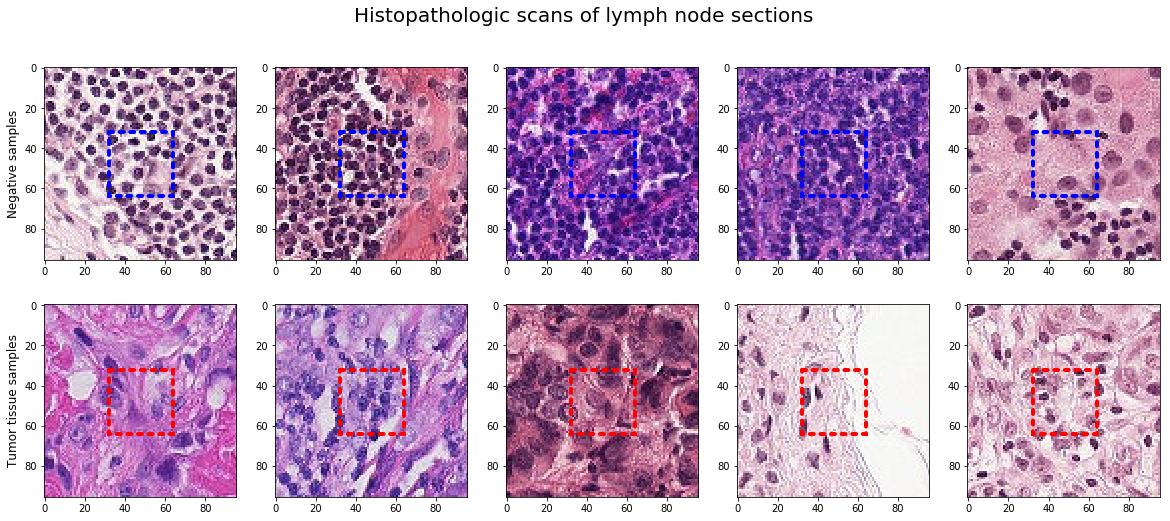

In [148]:
# random sampling
shuffled_data = shuffle(df)

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='b',facecolor='none', linestyle=':', capstyle='round')
    ax[0,i].add_patch(box)
ax[0,0].set_ylabel('Negative samples', size='large')
# Positives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
    path = os.path.join(train_path, idx)
    print(idx)
    ax[1,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
    ax[1,i].add_patch(box)
ax[1,0].set_ylabel('Tumor tissue samples', size='large')

# Data augmentation

In [19]:
tfms = get_transforms(flip_vert=True, max_rotate=10., max_zoom=.2,  max_lighting=0.05, max_warp=0.  )

In [20]:
np.random.seed(42)
src = (ImageItemList.from_csv(path=path_input, csv_name='train_labels.csv', folder='train', suffix='.tif')
       .random_split_by_pct(0.2)
       .label_from_df(col='label'))     

In [21]:
data =  (src.transform(tfms, size=96)
         .add_test_folder('test')
       .databunch(bs=bs).normalize(imagenet_stats)
       )

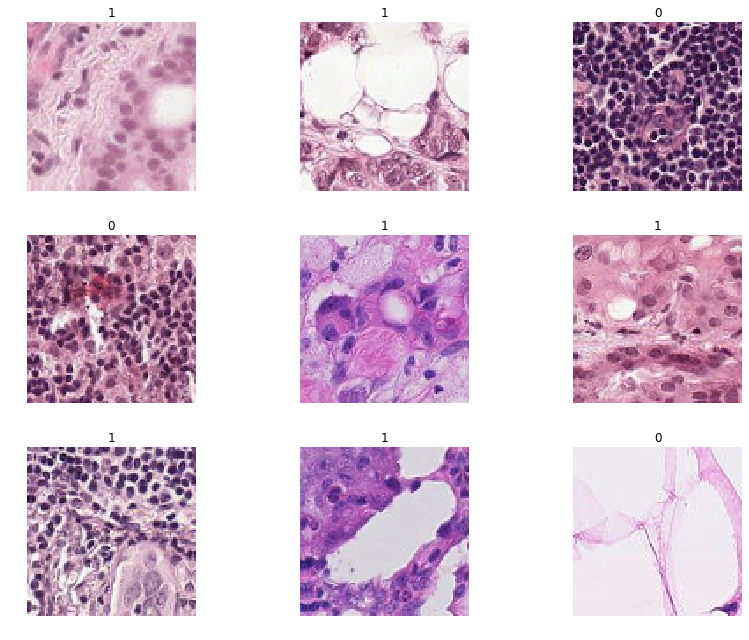

In [22]:
data.show_batch(rows=3, figsize=(12,9))

In [23]:
data.classes, len(data.train_ds), len(data.valid_ds), len(data.test_ds)

([0, 1], 176020, 44005, 57458)

In [24]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

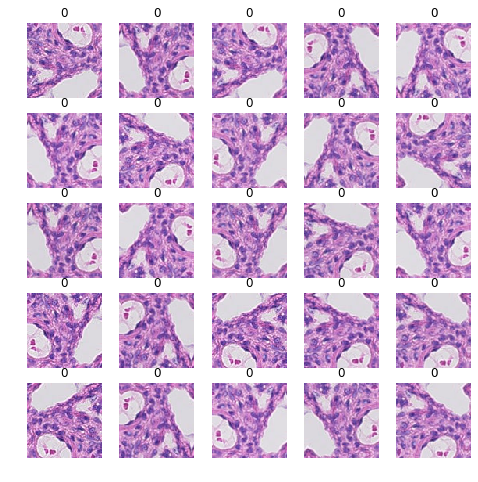

In [26]:
plot_multi(_plot, 5, 5, figsize=(8,8)) #transform results

# Train model

In [27]:
arch = models.resnet152
model_name = 'rn152' 

In [28]:
f1=Fbeta_binary(beta2=1)

In [29]:
gc.collect()
learn = create_cnn(data, arch, metrics=[accuracy, f1], ps=0.5) #dropout(ps)

In [208]:
#if you have trained a network before load those weights
learn.load('final-{0}'.format(model_name)) 

RuntimeError: Error(s) in loading state_dict for Sequential:
	Unexpected key(s) in state_dict: "1.9.weight", "1.9.bias", "1.9.running_mean", "1.9.running_var", "1.9.num_batches_tracked". 

In [13]:
learn.load('stage-2-{0}'.format(model_name) )

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (176020 items)
[Category 0, Category 1, Category 0, Category 0, Category 0]...
Path: ../input
x: ImageItemList (176020 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: ../input;

Valid: LabelList
y: CategoryList (44005 items)
[Category 0, Category 1, Category 0, Category 0, Category 1]...
Path: ../input
x: ImageItemList (44005 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: ../input;

Test: LabelList
y: CategoryList (57458 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: ../input
x: ImageItemList (57458 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: ../input, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps

In [30]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


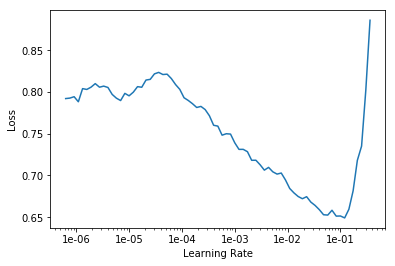

In [31]:
learn.recorder.plot()

In [33]:
lr = 1e-2

In [35]:
learn.fit_one_cycle(1, max_lr=lr)

epoch,train_loss,valid_loss,accuracy,fbeta_binary
1,0.191155,0.155997,0.943597,0.928789


In [36]:
learn.save('stage-1-{0}'.format(model_name) )

In [38]:
learn.unfreeze()
learn.fit_one_cycle(1, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,fbeta_binary
1,0.154654,0.140541,0.948892,0.936092


In [39]:
learn.save('stage-2-{0}'.format(model_name) )

In [96]:
#resize the images
#data = (src.transform(tfms, size=96)
#        .databunch(bs=bs).normalize(imagenet_stats))

#learn.data = data
#data.train_ds[0][0].shape

torch.Size([3, 96, 96])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


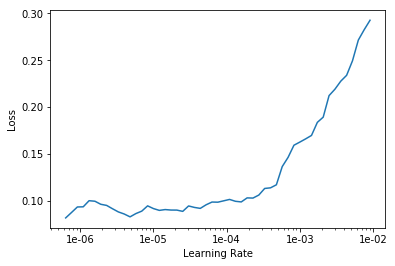

In [180]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [143]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,fbeta_binary
1,0.167548,0.137517,0.949733,0.936411
2,0.140273,0.121101,0.955914,0.944915


In [144]:
learn.save('stage-3-{0}'.format(model_name) )

In [145]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,accuracy,fbeta_binary
1,0.149087,0.120675,0.955846,0.944245
2,0.142408,0.118264,0.957891,0.947215


In [146]:
learn.save('stage-4-{0}'.format(model_name) )

In [147]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(5e-6, 5e-5))

epoch,train_loss,valid_loss,accuracy,fbeta_binary
1,0.139574,0.121408,0.956414,0.945106
2,0.125355,0.114467,0.958777,0.948251
3,0.114813,0.106196,0.962482,0.953015


In [148]:
learn.save('stage-5-{0}'.format(model_name) )

In [162]:
learn.load('stage-5-{0}'.format(model_name) )

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (176020 items)
[Category 0, Category 1, Category 0, Category 0, Category 0]...
Path: ../input
x: ImageItemList (176020 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: ../input;

Valid: LabelList
y: CategoryList (44005 items)
[Category 0, Category 1, Category 0, Category 0, Category 1]...
Path: ../input
x: ImageItemList (44005 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: ../input;

Test: LabelList
y: CategoryList (57458 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: ../input
x: ImageItemList (57458 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: ../input, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps

In [163]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(5e-6, 5e-5))

epoch,train_loss,valid_loss,accuracy,fbeta_binary
1,0.124459,0.108079,0.961232,0.951443
2,0.112452,0.104438,0.962368,0.952944
3,0.104379,0.098726,0.965186,0.956457


In [164]:
learn.save('stage-6-{0}'.format(model_name) )

In [181]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(5e-7, 5e-6))

epoch,train_loss,valid_loss,accuracy,fbeta_binary
1,0.097158,0.092768,0.967981,0.960277
2,0.098135,0.091404,0.967640,0.959912


In [182]:
learn.save('stage-7-{0}'.format(model_name) )

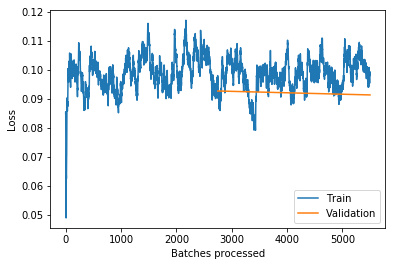

In [183]:
learn.recorder.plot_losses()

In [168]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-6, 1e-5))

epoch,train_loss,valid_loss,accuracy,fbeta_binary
1,0.102177,0.097162,0.965299,0.956721
2,0.111618,0.096286,0.965845,0.957534
3,0.104776,0.093201,0.966663,0.958511
4,0.102391,0.092819,0.967254,0.959553
5,0.112770,0.092786,0.966686,0.958529


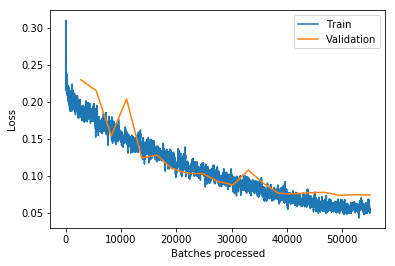

In [32]:
learn.recorder.plot_losses()

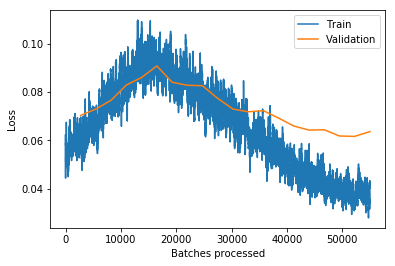

In [550]:
RN34

In [184]:
learn.save('final-{0}'.format(model_name) )

# Interpretation

In [185]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

## Most wrong predictions

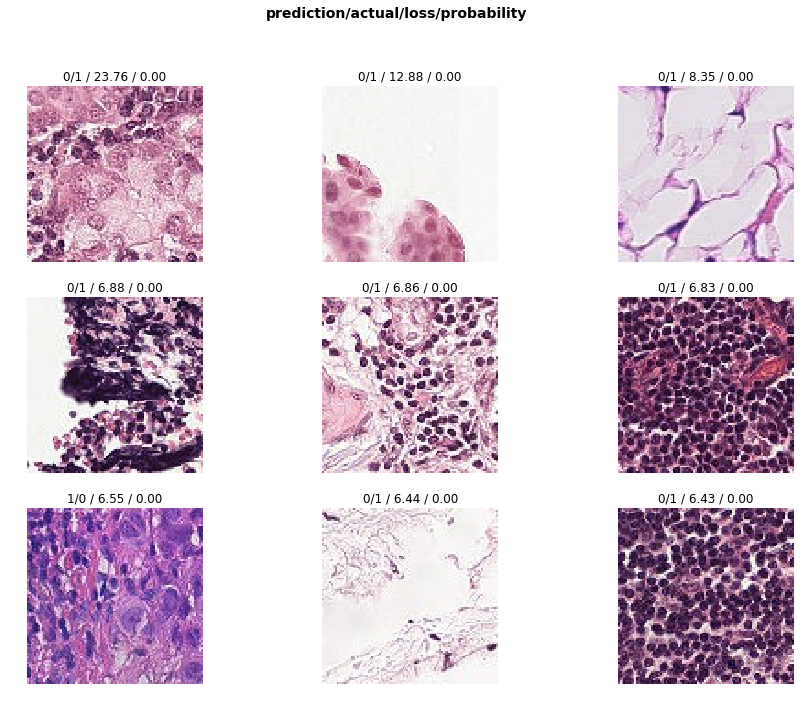

In [186]:
interp.plot_top_losses(9, figsize=(15,11))

## Confusion matrix

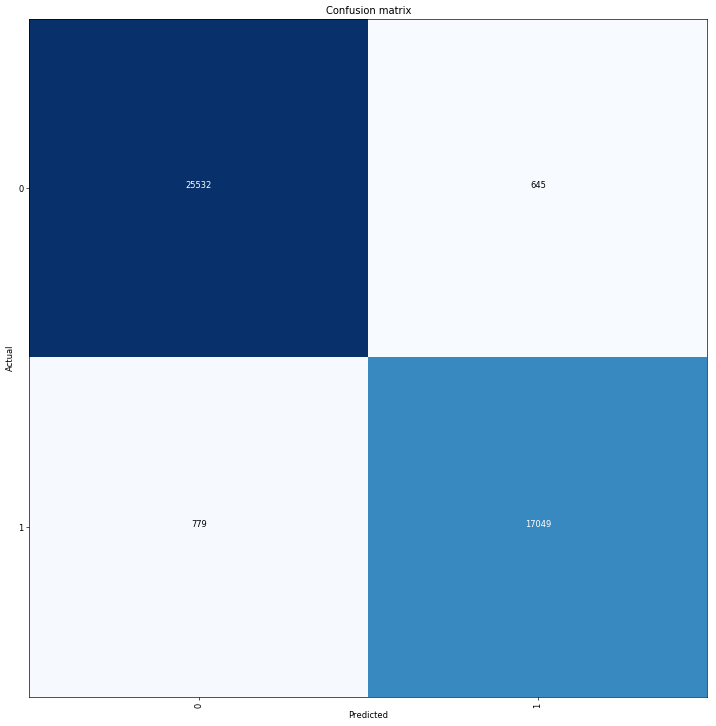

In [187]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# Heatmap

Category 1

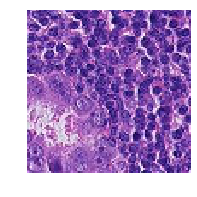

In [64]:
idx=1
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [65]:
from fastai.callbacks.hooks import *

In [66]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [131]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,96,96,0),
              interpolation='bilinear', cmap='magma');

In [132]:
m = learn.model.eval();

In [133]:
m[0]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1

In [134]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 64, 48, 48]     9408       True      
______________________________________________________________________
BatchNorm2d          [64, 64, 48, 48]     128        True      
______________________________________________________________________
ReLU                 [64, 64, 48, 48]     0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 24, 24]     0          False     
______________________________________________________________________
Conv2d               [64, 64, 24, 24]     4096       True      
______________________________________________________________________
BatchNorm2d          [64, 64, 24, 24]     128        True      
______________________________________________________________________
Conv2d               [64, 64, 24, 24]     36864      True      
______________________________________________________________

Category 1

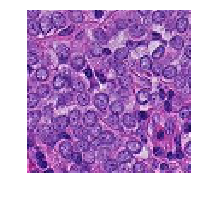

In [135]:
idx=4 #4 = category 1
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [136]:
xb,_ = data.one_item(x) #create the minibatch with one item
xb

tensor([[[[-0.3369,  0.7933,  0.9303,  ...,  0.3823,  0.4508,  0.9646],
          [ 0.1254, -0.6109,  0.5364,  ...,  0.2624,  0.2111,  1.4954],
          [-0.0458,  0.8789,  0.1597,  ...,  0.1254,  0.0569,  0.0056],
          ...,
          [ 2.1290,  0.6906,  0.7591,  ...,  0.1597, -0.4226, -0.2684],
          [ 1.9064,  0.6734,  0.4166,  ..., -0.1828,  0.0741,  0.6392],
          [ 1.2728,  1.4269,  0.0398,  ...,  0.7933, -0.4054,  0.1083]],

         [[-0.9853,  0.1527,  0.2752,  ..., -0.4601, -0.4951, -0.0224],
          [-0.5651, -1.3354, -0.1975,  ..., -0.5826, -0.6877,  0.5553],
          [-0.8627,  0.0826, -0.6527,  ..., -0.6702, -0.8277, -0.9503],
          ...,
          [ 0.0126, -1.3354, -1.0378,  ..., -0.6352, -1.1429, -0.9328],
          [-0.2325, -1.2654, -1.0903,  ..., -1.0903, -0.8803, -0.3725],
          [-0.7927, -0.3025, -1.2129,  ..., -0.2150, -1.5980, -1.1604]],

         [[ 0.6182,  1.8208,  2.0648,  ...,  1.3502,  1.2282,  1.6640],
          [ 1.0539,  0.3568,  

In [137]:
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()
xb

tensor([[[[-0.3369,  0.7933,  0.9303,  ...,  0.3823,  0.4508,  0.9646],
          [ 0.1254, -0.6109,  0.5364,  ...,  0.2624,  0.2111,  1.4954],
          [-0.0458,  0.8789,  0.1597,  ...,  0.1254,  0.0569,  0.0056],
          ...,
          [ 2.1290,  0.6906,  0.7591,  ...,  0.1597, -0.4226, -0.2684],
          [ 1.9064,  0.6734,  0.4166,  ..., -0.1828,  0.0741,  0.6392],
          [ 1.2728,  1.4269,  0.0398,  ...,  0.7933, -0.4054,  0.1083]],

         [[-0.9853,  0.1527,  0.2752,  ..., -0.4601, -0.4951, -0.0224],
          [-0.5651, -1.3354, -0.1975,  ..., -0.5826, -0.6877,  0.5553],
          [-0.8627,  0.0826, -0.6527,  ..., -0.6702, -0.8277, -0.9503],
          ...,
          [ 0.0126, -1.3354, -1.0378,  ..., -0.6352, -1.1429, -0.9328],
          [-0.2325, -1.2654, -1.0903,  ..., -1.0903, -0.8803, -0.3725],
          [-0.7927, -0.3025, -1.2129,  ..., -0.2150, -1.5980, -1.1604]],

         [[ 0.6182,  1.8208,  2.0648,  ...,  1.3502,  1.2282,  1.6640],
          [ 1.0539,  0.3568,  

In [138]:
hook_a,hook_g = hooked_backward()


In [139]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([2048, 3, 3])

In [140]:
avg_acts = acts.mean(0) #mean of the channels
avg_acts.shape

torch.Size([3, 3])

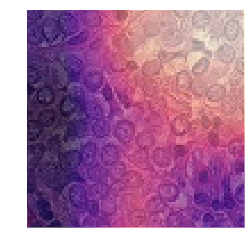

In [141]:
show_heatmap(avg_acts)

In [142]:
pred_class,pred_idx,outputs = learn.predict(x)
pred_class

Category 1

In [105]:
fn = f'{path_input}train/c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif'



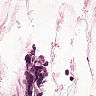

In [106]:
x = open_image(fn); x

In [51]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [52]:
hook_a,hook_g = hooked_backward()

In [53]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([2048, 3, 3])

In [54]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([3, 3])

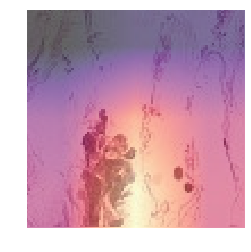

In [55]:
show_heatmap(avg_acts)

In [56]:
pred_class,pred_idx,outputs = learn.predict(x)
pred_class

Category 0

# Grad-CAM

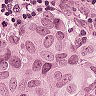

In [107]:
fn2 = f'{path_input}test/ad15cf4e12c953fd5822eec528c55a54fccaeae8.tif'
x = open_image(fn2); x

In [58]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [59]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([2048, 3, 3]), torch.Size([2048]))

In [60]:
mult = (acts*grad_chan[...,None,None]).mean(0)

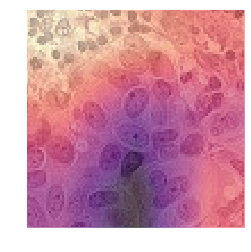

In [61]:
show_heatmap(mult)

In [62]:
pred_class,pred_idx,outputs = learn.predict(x)
pred_class

Category 1

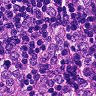

In [108]:
fn = f'{path_input}/train/0ec8c370c4f8e05a0a251d4d7c9664d2ca064fc5.tif'
x = open_image(fn); x

In [64]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [65]:
hook_a,hook_g = hooked_backward()

In [66]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

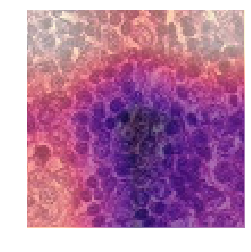

In [67]:
show_heatmap(mult)

In [68]:
pred_class,pred_idx,outputs = learn.predict(x)
pred_class

Category 1

# Predictions

In [188]:
from sklearn.metrics import *

In [189]:
def auc_score(y_score,y_true):
    return torch.tensor(roc_auc_score(y_true,y_score[:,1])) # use as metric


In [190]:
val_preds, val_labels = learn.get_preds(DatasetType.Valid)

In [191]:
pred_score = auc_score(val_preds,val_labels) 
pred_score



tensor(0.9939)

In [192]:
#learn.data = (src.add_test_folder('test')
 #             .transform(tfms, size=96)
 #             .databunch()
 #             .normalize(imagenet_stats))


In [193]:
preds, targets = learn.get_preds(DatasetType.Test)

In [194]:
learn.data.test_ds

LabelList
y: CategoryList (57458 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: ../input
x: ImageItemList (57458 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: ../input

In [195]:
preds_tta = learn.TTA(ds_type=DatasetType.Test)[0]

In [196]:
test_y = preds_tta
#test_y = test_y.to('cpu').detach().numpy()
test_y

tensor([[2.5799e-01, 7.4201e-01],
        [6.9348e-04, 9.9931e-01],
        [8.2502e-01, 1.7498e-01],
        ...,
        [9.8634e-01, 1.3663e-02],
        [9.8176e-01, 1.8241e-02],
        [9.8584e-01, 1.4155e-02]])

In [197]:
test_y = test_y[:,1]
test_y

tensor([0.7420, 0.9993, 0.1750,  ..., 0.0137, 0.0182, 0.0142])

In [198]:
submission_df = data.test_ds.to_df()
submission_df.head()


,x,y
0,test/daaac65c384d235e976ea97d2291aace14117ca6.tif,0
1,test/304a9c4006d6a3ee6162acb78c9bc888ce011987.tif,0
2,test/11190169984dc13e3b6cea262de280355ea400b1.tif,0
3,test/56c8afa2a0e2d929611454eb930d3c5b0aa823f1.tif,0
4,test/857cb7887fdd47a4c879bf5c9204ae9aebff96fe.tif,0


In [199]:
submission_df.columns = ['id', 'label']
#submission_df['label'] = (test_y.numpy() > 0.50).astype(int)
submission_df['label'] = test_y

submission_df['id'] = submission_df['id'].apply(lambda fp: Path(fp).stem)
submission_df.head()

,id,label
0,daaac65c384d235e976ea97d2291aace14117ca6,0.742005
1,304a9c4006d6a3ee6162acb78c9bc888ce011987,0.999307
2,11190169984dc13e3b6cea262de280355ea400b1,0.174978
3,56c8afa2a0e2d929611454eb930d3c5b0aa823f1,0.560703
4,857cb7887fdd47a4c879bf5c9204ae9aebff96fe,0.075021


In [200]:
submission_df.to_csv('hc_submission.csv.gz', index=False, float_format='%.7f', compression='gzip')

In [203]:
!kaggle competitions submit -c histopathologic-cancer-detection -f hc_submission.csv.gz -m "Submission " 

100%|███████████████████████████████████████| 1.58M/1.58M [00:06<00:00, 254kB/s]
Successfully submitted to Histopathologic Cancer Detection